# This notebook offers some experiments on the paper:


"Globally and Locally Consistent Image Completion", SATOSHI IIZUKA, EDGAR SIMO-SERRA,
HIROSHI ISHIKAWA

The employed code comes from https://github.com/akmtn/pytorch-siggraph2017-inpainting

It requires a PyTorch version below 1.0.

In [1]:
%load_ext autoreload
%autoreload 2

from src.masking import run_draw
from src.inpaint import inpainting, load_network, random_mask, load_mask, load_data
import cv2
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
import urllib

model, datamean = load_network()
filename = "completionnet_places2.t7"
url = "http://hi.cs.waseda.ac.jp/~iizuka/data/completionnet_places2.t7"

if not os.path.isfile(filename):
    urllib.urlretrieve(url, filename)

# 1. Simple tests on an image
Code from https://stackoverflow.com/a/36382158/4986615

Press ESC to quit the windows.

In [29]:
img = cv2.imread("images/bridge.jpg")
run_draw(img, "mask.png")

Save image


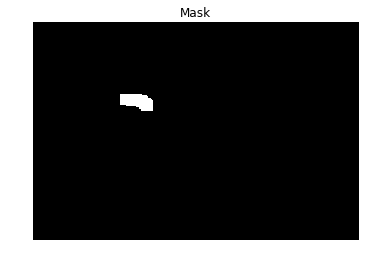

In [30]:
plt.figure()
mask = cv2.imread("mask.png")
plt.imshow(mask)
plt.axis('off')
plt.title("Mask")
plt.show()

In [50]:
M = load_mask("mask.png", output_shape=(600, 400))
I = load_data("images/bridge.jpg", output_shape=(600, 400))
out = inpainting(model, datamean, I, M, postproc=False)
vutils.save_image(out, 'out.png', normalize=True)

In [54]:
import torch
from src.inpaint import tensor2cvimg 
from src.poissonblending import blend


M_3ch = torch.cat((M, M, M), 0)

# target = np.rollaxis(I.numpy(), 0, 3)   # background
target = tensor2cvimg(I.numpy())
source = tensor2cvimg(out.numpy())    # foreground
# mask = np.rollaxis(M_3ch.numpy(), 0, 3)
mask = tensor2cvimg(M_3ch.numpy())
out2 = blend(target, source, mask, offset=(0, 0))
# out = torch.from_numpy(cvimg2tensor(out))

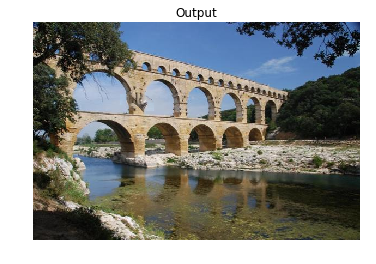

In [57]:
plt.imshow(out2[:,:,::-1])
plt.axis('off')
plt.title("Output")
plt.show()

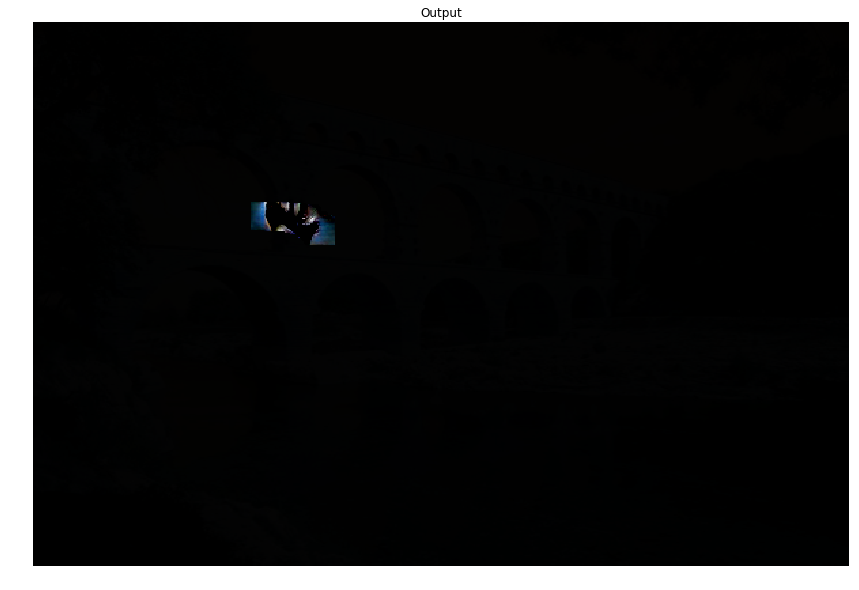

In [49]:
plt.figure(figsize=(20,10))
out = cv2.imread("out.png")[:,:,::-1] 
plt.imshow(out)
plt.axis('off')
plt.title("Output")
plt.show()

# 2. Computation of the loss function on a set of random masks
Here we want to draw a metric for the quality of the reconstruction.
We use a sum of a weighted MSE and a binary cross entropy as in the reference paper for training the generator.

In [ ]:
from torch.nn.modules.loss import BCELoss
    
bce_loss = nn.BCELoss()

img = cv2.imread("images/bridge.jpg")

weights = np.ones_like(img)*


      errG_l2 = criterionMSE:forward(input_center, input_real_center)
      local df_dg_l2 = criterionMSE:backward(input_center, input_real_center)

      if opt.overlapPred==0 then
        if (opt.wtl2>0 and opt.wtl2<1) then
          df_dg:mul(1-opt.wtl2):add(opt.wtl2,df_dg_l2)
          errG_total = (1-opt.wtl2)*errG + opt.wtl2*errG_l2